In [1]:
from pathlib import Path
import sys 

CWD = Path.cwd().resolve()
project_root = Path.cwd().parents[2]
sys.path.append(str(project_root))
from src.utils.common.isotope import Radionuclide_lara

{'Nuclide': 'Cs-137', 'Element': 'Cesium', 'Z': '55', 'Daughter(s)': ['(B-)', 'Ba-137', '100'], 'Q-': '1175.63', 'Possible parent(s)': ['(B-)', 'Xe-137', '100'], 'Half-life (a)': ['30.018', '0.022'], 'Half-life (s)': ['947.3E6', '0.7E6'], 'Decay constant (1/s)': ['731.7E-12', '0.5E-12'], 'Specific activity (Bq/g)': ['3.2165E12', '0.0024E12'], 'Reference': 'CEA/LNE-LNHB - 2023', 'Emissions': [{'Energy (keV)': '4.8824', 'Ener. unc. (keV)': '', 'Intensity (%)': '0.919', 'Int. unc. (%)': '0.016', 'Type': 'XL', 'Origin': 'Ba', 'Lvl. start': '', 'Lvl. end': ''}, {'Energy (keV)': '31.8174', 'Ener. unc. (keV)': '', 'Intensity (%)': '1.99', 'Int. unc. (%)': '0.04', 'Type': 'XKa2', 'Origin': 'Ba', 'Lvl. start': '', 'Lvl. end': ''}, {'Energy (keV)': '32.1939', 'Ener. unc. (keV)': '', 'Intensity (%)': '3.66', 'Int. unc. (%)': '0.06', 'Type': 'XKa1', 'Origin': 'Ba', 'Lvl. start': '', 'Lvl. end': ''}, {'Energy (keV)': '36.4457', 'Ener. unc. (keV)': '', 'Intensity (%)': '1.078', 'Int. unc. (%)': '0.0

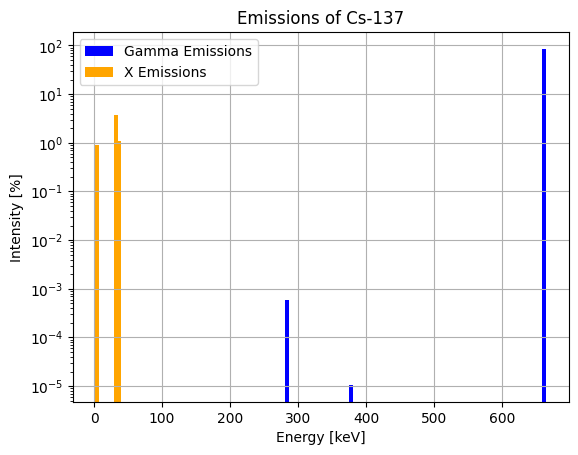

In [2]:
cesium = Radionuclide_lara("Cs-137")
print(cesium.radionuclide_data)
energy, intensity, types = cesium.get_rays_emission_data(photon_only=False)
cesium.plot_emissions(saving_figure=False, photon_only=False, log_scale=True)

{'Nuclide': 'Eu-152', 'Element': 'Europium', 'Z': '63', 'Daughter(s)': ['(B+, EC)', 'Sm-152', '72.1', '(B-)', 'Gd-152', '27.9'], 'Q+': ['1874.3', 'Q-', '1818.8'], 'Half-life (a)': ['13.522', '0.016'], 'Half-life (s)': ['426.7E6', '0.5E6'], 'Decay constant (1/s)': ['1.6244E-9', '0.0019E-9'], 'Specific activity (Bq/g)': ['6.436E12', '0.008E12'], 'Reference': 'USP, LBNL - 2004', 'Emissions': [{'Energy (keV)': '6.395', 'Ener. unc. (keV)': '', 'Intensity (%)': '13.0', 'Int. unc. (%)': '0.4', 'Type': 'XL', 'Origin': 'Sm-152', 'Lvl. start': '', 'Lvl. end': ''}, {'Energy (keV)': '6.73255', 'Ener. unc. (keV)': '', 'Intensity (%)': '0.177', 'Int. unc. (%)': '0.005', 'Type': 'XL', 'Origin': 'Gd-152', 'Lvl. start': '', 'Lvl. end': ''}, {'Energy (keV)': '39.5229', 'Ener. unc. (keV)': '', 'Intensity (%)': '20.8', 'Int. unc. (%)': '0.3', 'Type': 'XKa2', 'Origin': 'Sm-152', 'Lvl. start': '', 'Lvl. end': ''}, {'Energy (keV)': '40.1186', 'Ener. unc. (keV)': '', 'Intensity (%)': '37.7', 'Int. unc. (%)': 

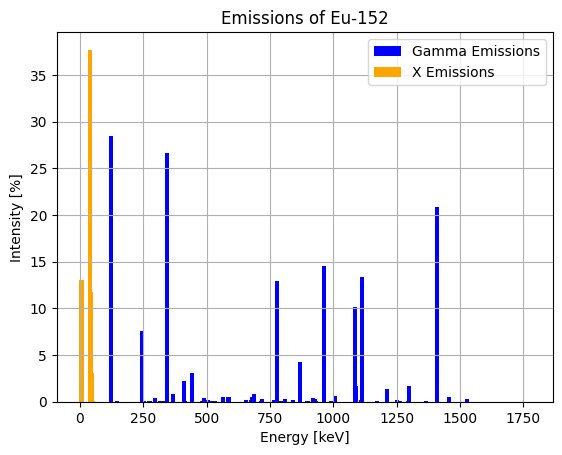

In [3]:
europium = Radionuclide_lara("Eu-152")
print(europium.radionuclide_data)
energy, intensity, types = europium.get_rays_emission_data(photon_only=False)
print(f"Energy: {energy}, Intensity: {intensity}, Types: {types}")
europium.plot_emissions(saving_figure=False, photon_only=False, log_scale=False)

{'Nuclide': 'U-238', 'Element': 'Uranium', 'Z': '92', 'Daughter(s)': ['(alpha)', 'Th-234', '100'], 'Qalpha': '4269.7', 'Possible parent(s)': ['(alpha)', 'Pu-242', '100'], 'Half-life (a)': ['4.468E9', '0.005E9'], 'Half-life (s)': ['141.00E15', '0.16E15'], 'Decay constant (1/s)': ['4.916E-18', '0.006E-18'], 'Specific activity (Bq/g)': ['12.439E3', '0.014E3'], 'Reference': 'CEA/LNE-LNHB - 2006', 'Emissions': [{'Energy (keV)': '15.311', 'Ener. unc. (keV)': '', 'Intensity (%)': '7.94', 'Int. unc. (%)': '0.28', 'Type': 'XL', 'Origin': 'Th-234', 'Lvl. start': '', 'Lvl. end': ''}, {'Energy (keV)': '49.55', 'Ener. unc. (keV)': '0.06', 'Intensity (%)': '0.0697', 'Int. unc. (%)': '0.0026', 'Type': 'g', 'Origin': 'Th-234', 'Lvl. start': '1', 'Lvl. end': '0'}, {'Energy (keV)': '89.954', 'Ener. unc. (keV)': '', 'Intensity (%)': '0.00109', 'Int. unc. (%)': '0.00030', 'Type': 'XKa2', 'Origin': 'Th-234', 'Lvl. start': '', 'Lvl. end': ''}, {'Energy (keV)': '93.351', 'Ener. unc. (keV)': '', 'Intensity (%

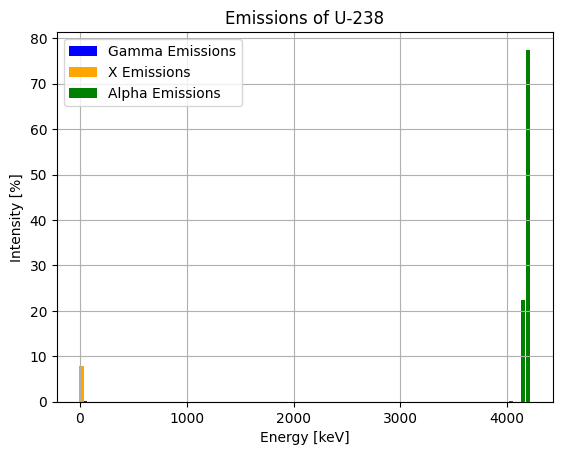

In [4]:
natural_uranium = Radionuclide_lara("U-238")
print(natural_uranium.radionuclide_data)
energy, intensity, types = natural_uranium.get_rays_emission_data(photon_only=False)
print(f"Energy: {energy}, Intensity: {intensity}, Types: {types}")
print(f"Half-life: {natural_uranium.get_half_life(unit='s')} s")
print(f"Decay constant: {natural_uranium.get_decay_constant()} 1/s")
print(f"Massic activity: {natural_uranium.get_massic_activity()} Bq/g")
natural_uranium.plot_emissions(saving_figure=False, photon_only=False, log_scale=False)

{'Nuclide': 'U-235', 'Element': 'Uranium', 'Z': '92', 'Daughter(s)': ['(alpha)', 'Th-231', '100'], 'Qalpha': '4678.3', 'Possible parent(s)': ['(B+, EC)', 'Np-235', '99.9986', '(alpha)', 'Pu-239', '100'], 'Half-life (a)': ['704E6', '1E6'], 'Half-life (s)': ['22.216E15', '0.032E15'], 'Decay constant (1/s)': ['31.200E-18', '0.044E-18'], 'Specific activity (Bq/g)': ['79.95E3', '0.11E3'], 'Reference': 'CNDC - 2014', 'Emissions': [{'Energy (keV)': '15.311', 'Ener. unc. (keV)': '', 'Intensity (%)': '40', 'Int. unc. (%)': '22', 'Type': 'XL', 'Origin': 'Th-231', 'Lvl. start': '', 'Lvl. end': ''}, {'Energy (keV)': '19.592', 'Ener. unc. (keV)': '0.006', 'Intensity (%)': '0.006', 'Int. unc. (%)': '0.006', 'Type': 'g', 'Origin': 'Th-231', 'Lvl. start': '5', 'Lvl. end': '4'}, {'Energy (keV)': '31.60', 'Ener. unc. (keV)': '0.05', 'Intensity (%)': '0.017', 'Int. unc. (%)': '0.006', 'Type': 'g', 'Origin': 'Th-231', 'Lvl. start': '7', 'Lvl. end': '5'}, {'Energy (keV)': '41.4', 'Ener. unc. (keV)': '0.3',

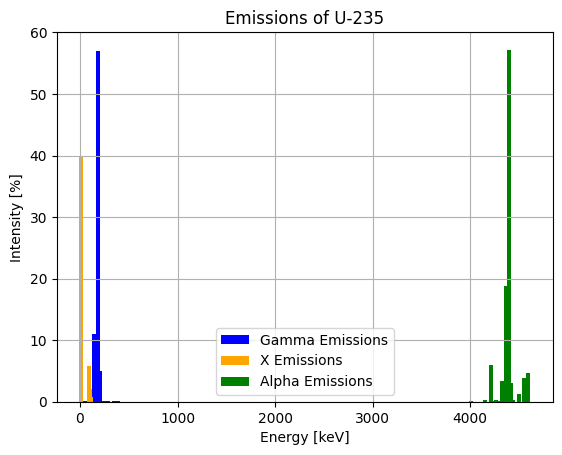

In [5]:
enriched_uranium = Radionuclide_lara("U-235")
print(enriched_uranium.radionuclide_data)
enriched_uranium.plot_emissions(saving_figure=False, photon_only=False, log_scale=False)